Contents:

EDA

data prep

defining cutout

model without regularization

model with regularization

model with cutout (failed)


In [1]:
import os
import pandas
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
#lets figure out how many data points we are working with:
sets= ["train","test","val"]
labels = ["NORMAL","PNEUMONIA"]
for s in sets:
    for label in labels:
        number_files = len(os.listdir(f"{s}/{label}"))
        print(f"Number of files in [{s}] with label = [{label}]: {number_files}")

Number of files in [train] with label = [NORMAL]: 1341
Number of files in [train] with label = [PNEUMONIA]: 3876
Number of files in [test] with label = [NORMAL]: 235
Number of files in [test] with label = [PNEUMONIA]: 390
Number of files in [val] with label = [NORMAL]: 8
Number of files in [val] with label = [PNEUMONIA]: 8


We can see that the dataset is not balanced, and the validation set is 8 which is likely too small. 

I'll work within the bounds of the kaggle set at first and use these sets, and see how resplitting our sets affects the outcome. 

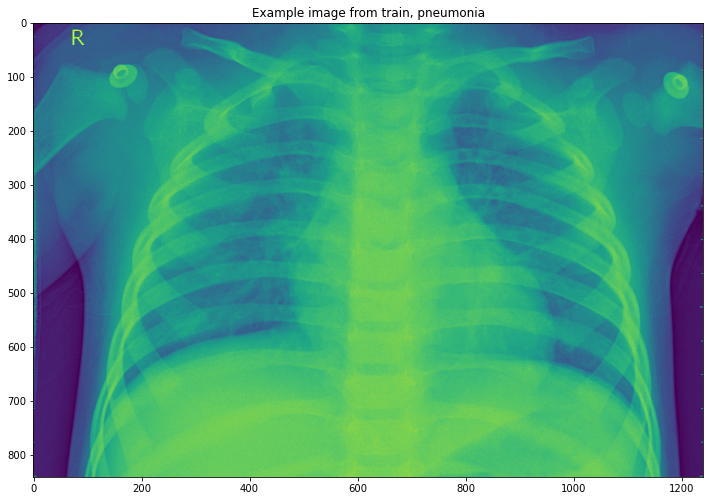

In [3]:
#what do the images look like?
img = cv2.imread("train/PNEUMONIA/person1_bacteria_2.jpeg",0)
plt.figure(figsize=(12, 12))
    
plt.title("Example image from train, pneumonia")
plt.imshow(img)
plt.show()

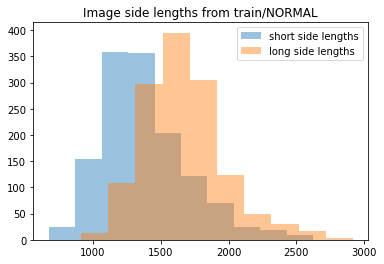

Non-jpeg found while reading data:
train/PNEUMONIA/.ipynb_checkpoints



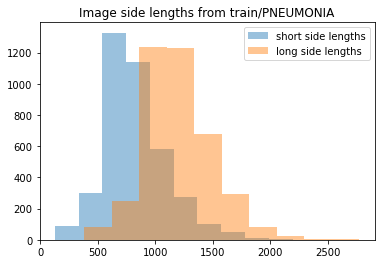

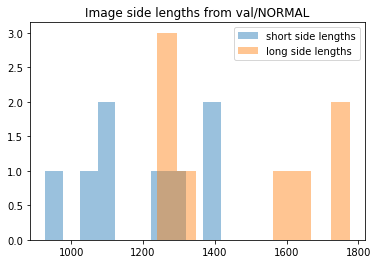

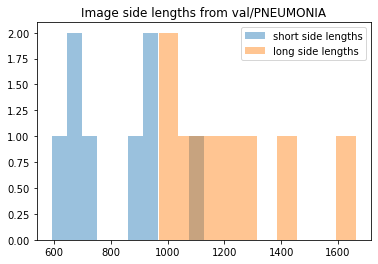

In [4]:
#this can take a minute to run and is unnecessary for seeing the model work. 

#lets see how the image sizes are:
sets = ["train","val"] # I'm intentionally avoiding the test set to prevent data leaks
for s in sets:
    for label in labels:
        file_names = os.listdir(f"{s}/{label}")
        image_shapes = []
        for file_name in file_names:
            if ".jpeg" in file_name: #sometimes ipynb checkpoints appear
                img = cv2.imread(f"{s}/{label}/{file_name}",0)
                image_shapes.append(img.shape)
            else:
                print(f"Non-jpeg found while reading data:\n{s}/{label}/{file_name}\n")
        plt.hist([np.minimum(x[0],x[1]) for x in image_shapes],alpha = .45,label = "short side lengths")
        plt.hist([np.maximum(x[0],x[1]) for x in image_shapes],alpha = .45,label = "long side lengths")
        plt.title(f"Image side lengths from {s}/{label}")
        plt.legend()
        plt.show()

The vast majority of images are over 500 pixels on both sides, I'm trying to avoid transforming the images too much before augmentation. Ultimately worrying too much about this wouldn't be reasonable; we are going to augment the images and we don't/wouldn't know much about the images this model would be applied to in practice. We'll start with a side length of 200, and potentially examine how changing it affects our outcome. 

In [5]:
#to help with memory usage, I normalize when reading in each image, this is likely unnecessary and is not particularly modular
def normalize(img):
    return img/255


def load_data_split(path,side_length = 200):
    data = []
    labels = []
    label_dict = {"NORMAL":0,"PNEUMONIA":1} #pneumonia will be class 1, normal will be class 0
    for label in label_dict:
        for file_name in os.listdir(f"{path}/{label}"):
            try:
                img = cv2.imread(f"{path}/{label}/{file_name}",0) #read in bw image
                img = cv2.resize(img,(side_length,side_length)) #stretch/squish to side_length
                img = normalize(img) #normalize
                data.append(img) 
                labels.append(label_dict[label]) #add the class number instead of string
            except:
                print(f"{path}/{label}/{file_name} failed to load as an image...") #purely for ipynb checkpoints
    labels = np.array(labels)
    data = np.array(data)
    return data,labels

X_train, y_train = load_data_split("train")
X_val, y_val = load_data_split("val")


train/PNEUMONIA/.ipynb_checkpoints failed to load as an image...


In [6]:
print(f"{X_train.shape = }")
print(f"{y_train.shape = }")
print(f"{X_val.shape = }")
print(f"{y_val.shape = }")

X_train.shape = (5216, 200, 200)
y_train.shape = (5216,)
X_val.shape = (16, 200, 200)
y_val.shape = (16,)


In [7]:
def add_channel(X):
    return np.expand_dims(X, axis =3)

X_train = add_channel(X_train)
X_val = add_channel(X_val)

In [8]:
def datagen_generator(rotation_range, horiz_flip,vert_flip,prep_fun):
    return  ImageDataGenerator(rotation_range = 30, 
                               horizontal_flip=False,
                               vertical_flip=False, 
                               preprocessing_function = prep_fun)
tf.random.set_seed(273495)
datagen = datagen_generator(rotation_range = 30,horiz_flip = False, vert_flip = False,prep_fun = None) #something to adjust

#potentially add cutout or noise to prep fun if not using dropout later.

**Cutout** is a regularization method which sets random recatangles of pixels to gray or zero or random noise.
I take some time here to define it for use in ImageDataGenerator, however I do not think it's suited for this usecase. It may make sense with classification such as CIFAR, however our classification problem is more restricted. At least from a human's perspective, pneumonia appears a nebulous haze, which is less complex than the pile of distinct features one might ascribe to a car for instance. 

In [9]:
def cutout_generator(cut_l,fill_brightness):
    def cutout(img):
        npad = ((cut_l, cut_l), (cut_l, cut_l), (0, 0))
        output = np.pad(image, pad_width = npad, mode = 'minimum')
        v_index = np.random.randint(0,img.shape[0] + cut_l) 
        h_index = np.random.randint(0,img.shape[1] + cut_l)
        output[v_index:v_index+cut_l,h_index:h_index+cut_l] = np.full((cut_l,cut_l,1),fill_brightness)
        return output[cut_l:-cut_l,cut_l:-cut_l]
    return cutout 

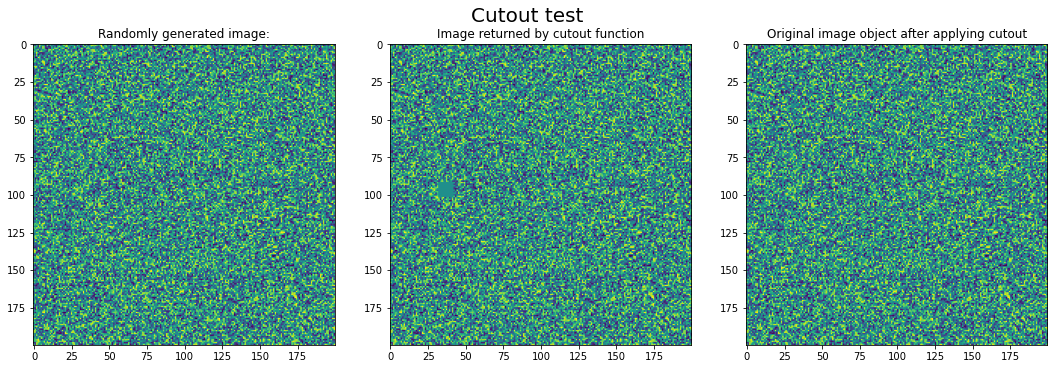

image shape after cutout = (200, 200, 1) ----- (should be 200,200,1).


In [10]:
#lets test out the new function 

cutout = cutout_generator(10,.5)
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

fig.suptitle('Cutout test', fontsize=20)

image = np.random.random((200,200,1))
ax1.imshow(image)
ax1.set_title(f"Randomly generated image:")

image2 = cutout(image)
ax2.imshow(image2)
ax2.set_title(f"Image returned by cutout function")

plt.imshow(image)
ax3.set_title(f"Original image object after applying cutout")

plt.tight_layout()
plt.show()
print(f"image shape after cutout = {image2.shape} ----- (should be 200,200,1).")

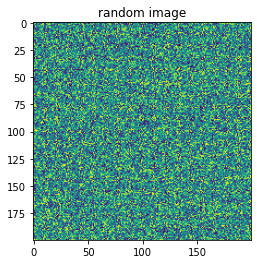

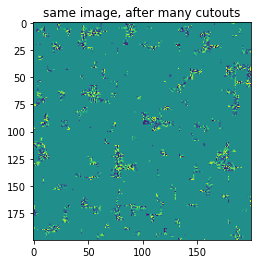

In [11]:
#just making sure each pixel can be cut, not really that important in the scope of this application 
#the function is also faster than I thought, this implementation is far from optimal, 
#the padding method is not ideal but has the benefit
#of creating a new object as to not edit the original. 

image = np.random.random((200,200,1))
plt.imshow(image)
plt.title("random image")
plt.show()
for i in range(1000):
    image = cutout(image)
plt.imshow(image)
plt.title("same image, after many cutouts")
plt.show()

In [12]:
#now that detour is over we can return to creating a model object and then applying it.
datagen.fit(X_train)

In [13]:
def model1_generator(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (5,5), strides = 1, padding = 'same', activation = 'relu', input_shape=input_shape))
    model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
    
    model.add(Conv2D(64, (5, 5), strides = 1, padding = 'same', activation = 'relu'))
    model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
    
    model.add(Conv2D(32, (3, 3), strides=1, padding = 'same', activation = 'relu'))
    model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
    
    model.add(Conv2D(32, (3, 3), strides = 1, padding = 'same', activation = 'relu'))
    model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
    
    model.add(Flatten())
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model
model1 = model1_generator((200,200,1))

Metal device set to: Apple M1 Max


2022-04-05 15:07:32.632770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-05 15:07:32.632922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
model1.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = ['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 64)      1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 32)        9

We need to randomize X, as it stands the labels are in order- which may not affect our outcome but it could potentially. 

In [15]:
tf.random.set_seed(5234)
indx = tf.random.shuffle(tf.range(0, len(X_train)))
X_train = tf.gather(X_train, indx)
y_train = tf.gather(y_train, indx)
datagen.fit(X_train)

In [16]:
epochs = 75
model1_history = model1.fit(datagen.flow(X_train, y_train, batch_size =20), 
                     epochs = epochs,
                     validation_data=(X_val, y_val), 
                     verbose = 2)
#~30minute runtime

2022-04-05 15:07:33.122926: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-05 15:07:33.123042: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-05 15:07:33.262983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/75
261/261 - 28s - loss: 0.3523 - accuracy: 0.8466 - val_loss: 0.5207 - val_accuracy: 0.6875


2022-04-05 15:08:01.531933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/75
261/261 - 28s - loss: 0.1580 - accuracy: 0.9404 - val_loss: 1.8028 - val_accuracy: 0.5625
Epoch 3/75
261/261 - 28s - loss: 0.1373 - accuracy: 0.9456 - val_loss: 0.3721 - val_accuracy: 0.8125
Epoch 4/75
261/261 - 28s - loss: 0.1242 - accuracy: 0.9572 - val_loss: 0.2477 - val_accuracy: 0.9375
Epoch 5/75
261/261 - 28s - loss: 0.1157 - accuracy: 0.9576 - val_loss: 0.6870 - val_accuracy: 0.6250
Epoch 6/75
261/261 - 28s - loss: 0.1079 - accuracy: 0.9599 - val_loss: 0.9213 - val_accuracy: 0.6250
Epoch 7/75
261/261 - 28s - loss: 0.1044 - accuracy: 0.9599 - val_loss: 0.3330 - val_accuracy: 0.8125
Epoch 8/75
261/261 - 28s - loss: 0.0970 - accuracy: 0.9643 - val_loss: 0.7386 - val_accuracy: 0.6250
Epoch 9/75
261/261 - 28s - loss: 0.0868 - accuracy: 0.9701 - val_loss: 0.1898 - val_accuracy: 0.8750
Epoch 10/75
261/261 - 28s - loss: 0.0857 - accuracy: 0.9693 - val_loss: 0.3946 - val_accuracy: 0.8125
Epoch 11/75
261/261 - 28s - loss: 0.0812 - accuracy: 0.9666 - val_loss: 0.2150 - val_accur

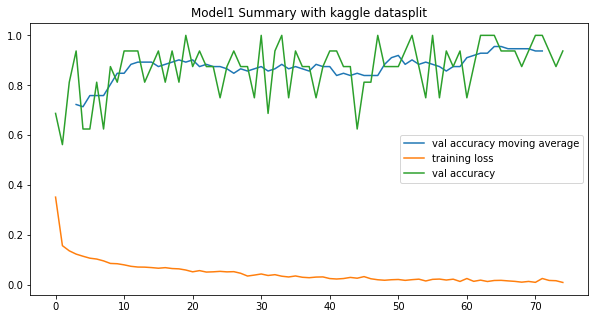

In [17]:
window_size = 7
smooth_val_accuracy = 3*[np.nan]
for i in range(int(window_size/2), int(76-np.ceil(window_size/2))):
    smooth_val_accuracy.append(np.mean(model1_history.history['val_accuracy'][i-int(window_size/2):int(i+np.ceil(window_size/2))]))
plt.figure(figsize=(10,5))
plt.plot(smooth_val_accuracy,label = "val accuracy moving average")
plt.plot(model1_history.history['loss'],label = "training loss")
plt.plot(model1_history.history['val_accuracy'],label = "val accuracy")
plt.legend()
plt.title("Model1 Summary with kaggle datasplit")
plt.show()

This brings up a few issues, as previously said the validation set is too small. Additionally, the model is improving its fit after 75 epochs, that normally would indicate overfitting however we also had a slight uptick in validation accuracy at the end. Without more than 16 validation points we cannot say if this uptick is significant. 

## Applying model1 (no regularization) after giving validation 200 more data points:

In [18]:
X_train, y_train = load_data_split("train")
X_val, y_val = load_data_split("val")

tf.random.set_seed(5234)
indx = tf.random.shuffle(tf.range(0, len(X_train)))

X_train = tf.gather(X_train, indx)
y_train = tf.gather(y_train, indx)

X_val = np.concatenate((X_val, X_train[:200]),axis =0)
y_val = np.concatenate((y_val, y_train[:200]),axis = 0)

X_train = X_train[200:]
y_train = y_train[200:]

train/PNEUMONIA/.ipynb_checkpoints failed to load as an image...


In [19]:
X_train = add_channel(X_train)
X_val = add_channel(X_val)
datagen.fit(X_train)

In [20]:
model1 = model1_generator((200,200,1))
model1.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = ['accuracy'])
epochs = 75
model1_history2 = model1.fit(datagen.flow(X_train, y_train, batch_size =20), 
                     epochs = epochs,
                     validation_data=(X_val, y_val), 
                     verbose = 2)

Epoch 1/75


2022-04-05 15:43:07.938684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-05 15:43:35.179691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


251/251 - 28s - loss: 0.3827 - accuracy: 0.8258 - val_loss: 0.2919 - val_accuracy: 0.9074
Epoch 2/75
251/251 - 27s - loss: 0.1879 - accuracy: 0.9262 - val_loss: 0.2132 - val_accuracy: 0.9352
Epoch 3/75
251/251 - 27s - loss: 0.1548 - accuracy: 0.9440 - val_loss: 0.1745 - val_accuracy: 0.9583
Epoch 4/75
251/251 - 27s - loss: 0.1233 - accuracy: 0.9549 - val_loss: 0.1604 - val_accuracy: 0.9444
Epoch 5/75
251/251 - 27s - loss: 0.1070 - accuracy: 0.9593 - val_loss: 0.1570 - val_accuracy: 0.9537
Epoch 6/75
251/251 - 27s - loss: 0.1107 - accuracy: 0.9613 - val_loss: 0.1516 - val_accuracy: 0.9491
Epoch 7/75
251/251 - 27s - loss: 0.1036 - accuracy: 0.9631 - val_loss: 0.1232 - val_accuracy: 0.9444
Epoch 8/75
251/251 - 27s - loss: 0.0899 - accuracy: 0.9671 - val_loss: 0.1539 - val_accuracy: 0.9398
Epoch 9/75
251/251 - 27s - loss: 0.0900 - accuracy: 0.9649 - val_loss: 0.1360 - val_accuracy: 0.9398
Epoch 10/75
251/251 - 27s - loss: 0.0853 - accuracy: 0.9677 - val_loss: 0.1062 - val_accuracy: 0.9491


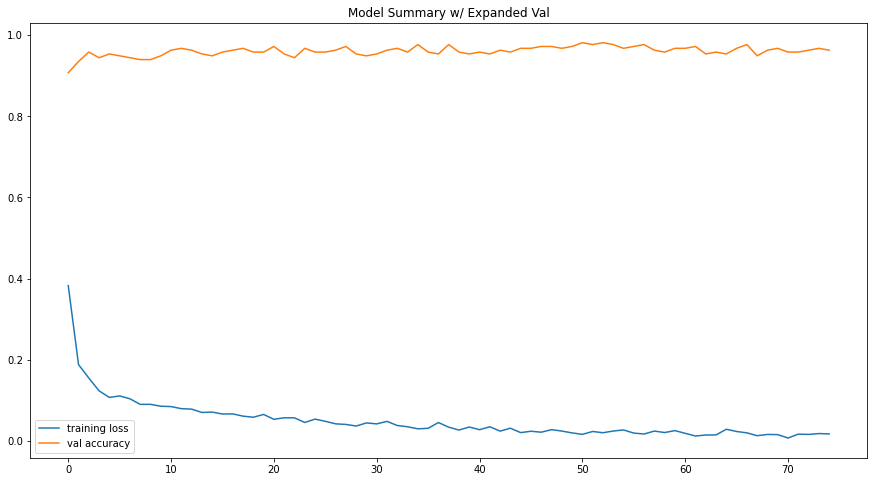

In [21]:
plt.figure(figsize=(15,8))
plt.plot(model1_history2.history['loss'],label = "training loss")
plt.plot(model1_history2.history['val_accuracy'],label = "val accuracy")
plt.legend()
plt.title("Model Summary w/ Expanded Val")
plt.show()

## Creating and applying model2 (model1 with batch norm and dropout added):

In [22]:
def model2_generator(input_shape):
    
    model = Sequential()
    
    model.add(Conv2D(64, (5,5), strides = 1, padding = 'same', activation = 'relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
    
    model.add(Conv2D(64, (5, 5), strides = 1, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
    
    model.add(Conv2D(32, (3, 3), strides=1, padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
    
    model.add(Conv2D(32, (3, 3), strides = 1, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
    
    model.add(Flatten())
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

model2 = model2_generator((200,200,1))
model2.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = ['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 200, 200, 64)      1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 64)      256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 64)      102464    
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 64)       

In [23]:
datagen.fit(X_train)
epochs = 75
model2_history = model2.fit(datagen.flow(X_train, y_train, batch_size =20), 
                     epochs = epochs,
                     validation_data=(X_val, y_val), 
                     verbose = 2)

Epoch 1/75


2022-04-05 16:17:12.543991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-05 16:17:43.418387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


251/251 - 31s - loss: 0.2201 - accuracy: 0.9209 - val_loss: 0.6834 - val_accuracy: 0.7407
Epoch 2/75
251/251 - 31s - loss: 0.1316 - accuracy: 0.9514 - val_loss: 0.3097 - val_accuracy: 0.8750
Epoch 3/75
251/251 - 31s - loss: 0.0972 - accuracy: 0.9633 - val_loss: 0.1444 - val_accuracy: 0.9444
Epoch 4/75
251/251 - 31s - loss: 0.0951 - accuracy: 0.9645 - val_loss: 0.1440 - val_accuracy: 0.9352
Epoch 5/75
251/251 - 31s - loss: 0.0813 - accuracy: 0.9695 - val_loss: 0.1285 - val_accuracy: 0.9583
Epoch 6/75
251/251 - 31s - loss: 0.0849 - accuracy: 0.9681 - val_loss: 0.2729 - val_accuracy: 0.9352
Epoch 7/75
251/251 - 31s - loss: 0.0708 - accuracy: 0.9735 - val_loss: 0.9603 - val_accuracy: 0.7407
Epoch 8/75
251/251 - 31s - loss: 0.0670 - accuracy: 0.9749 - val_loss: 0.1488 - val_accuracy: 0.9444
Epoch 9/75
251/251 - 31s - loss: 0.0642 - accuracy: 0.9769 - val_loss: 0.1339 - val_accuracy: 0.9583
Epoch 10/75
251/251 - 31s - loss: 0.0639 - accuracy: 0.9757 - val_loss: 0.1670 - val_accuracy: 0.9444


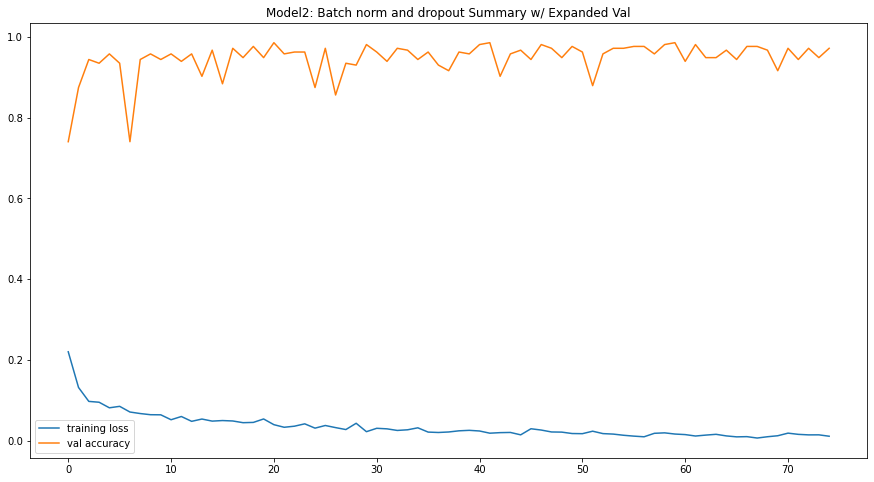

In [24]:
plt.figure(figsize=(15,8))
plt.plot(model2_history.history['loss'],label = "training loss")
plt.plot(model2_history.history['val_accuracy'],label = "val accuracy")
plt.legend()
plt.title("Model2: Batch norm and dropout Summary w/ Expanded Val")
plt.show()

Immediately one can see high variance in validation accuracy. If we look at training loss we see them comverge on one another.  However, looking closely will reveal that the validation accuracy is consistently under or equal to the model without regularization. This is concerning


## Applying model3 (model1 but with cutout included as a method of regularization).

In [25]:
tf.random.set_seed(9328457)
datagen = datagen_generator(rotation_range = 30,
                            horiz_flip = False, 
                            vert_flip = False,
                            prep_fun = cutout_generator(1,.5))

In [26]:
X_train, y_train = load_data_split("train")
X_val, y_val = load_data_split("val")

tf.random.set_seed(5234)
indx = tf.random.shuffle(tf.range(0, len(X_train)))

X_train = tf.gather(X_train, indx)
y_train = tf.gather(y_train, indx)

X_val = np.concatenate((X_val, X_train[:200]),axis = 0)
y_val = np.concatenate((y_val, y_train[:200]),axis = 0)

X_train = X_train[200:]
y_train = y_train[200:]

train/PNEUMONIA/.ipynb_checkpoints failed to load as an image...


In [27]:
X_train = add_channel(X_train)
X_val = add_channel(X_val)

datagen.fit(X_train)

In [28]:
model3 = model1_generator((200,200,1))
model3.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = ['accuracy'])

In [29]:
epochs = 75
model3_history = model3.fit(datagen.flow(X_train, y_train, batch_size =20), 
                     epochs = epochs,
                     validation_data=(X_val, y_val),
                     verbose = 1)

Epoch 1/75


2022-04-05 16:56:12.250967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - ETA: 0s - loss: 0.5808 - accuracy: 0.7410

2022-04-05 16:56:40.395230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - 28s 113ms/step - loss: 0.5808 - accuracy: 0.7410 - val_loss: 0.5996 - val_accuracy: 0.7407
Epoch 2/75
251/251 [==============================] - 28s 112ms/step - loss: 0.5751 - accuracy: 0.7422 - val_loss: 0.5731 - val_accuracy: 0.7407
Epoch 3/75
251/251 [==============================] - 28s 112ms/step - loss: 0.5736 - accuracy: 0.7422 - val_loss: 0.5731 - val_accuracy: 0.7407
Epoch 4/75
251/251 [==============================] - 28s 113ms/step - loss: 0.5743 - accuracy: 0.7422 - val_loss: 0.5728 - val_accuracy: 0.7407
Epoch 5/75
251/251 [==============================] - 28s 113ms/step - loss: 0.5728 - accuracy: 0.7422 - val_loss: 0.5726 - val_accuracy: 0.7407
Epoch 6/75
251/251 [==============================] - 28s 112ms/step - loss: 0.5740 - accuracy: 0.7422 - val_loss: 0.5738 - val_accuracy: 0.7407
Epoch 7/75
251/251 [==============================] - 28s 112ms/step - loss: 0.5723 - accuracy: 0.7422 - val_loss: 0.5745 - val_accuracy: 0.7

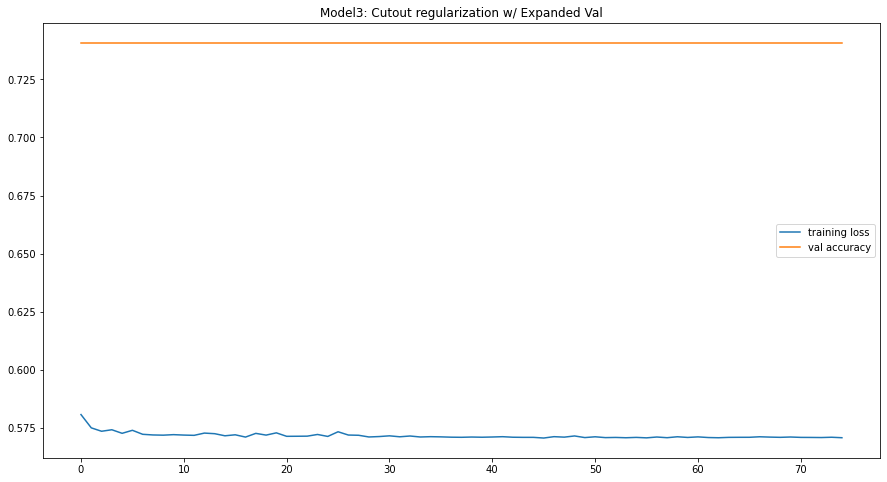

In [30]:
plt.figure(figsize=(15,8))
plt.plot(model3_history.history['loss'],label = "training loss")
plt.plot(model3_history.history['val_accuracy'],label = "val accuracy")
plt.legend()
plt.title("Model3: Cutout regularization w/ Expanded Val")
plt.show()

## Comparing the models against one another:

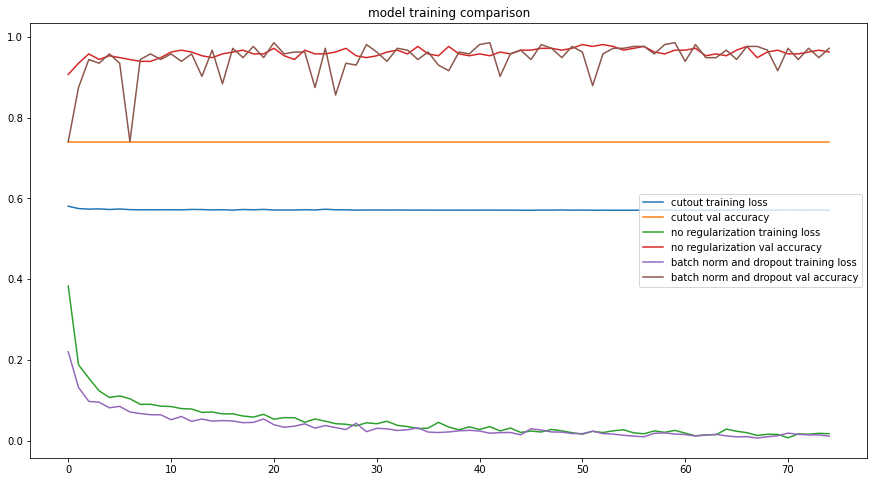

In [31]:
plt.figure(figsize=(15,8))
plt.plot(model3_history.history['loss'],label = "cutout training loss")
plt.plot(model3_history.history['val_accuracy'],label = "cutout val accuracy")

plt.plot(model1_history2.history['loss'],label = "no regularization training loss")
plt.plot(model1_history2.history['val_accuracy'],label = "no regularization val accuracy")

plt.plot(model2_history.history['loss'],label = "batch norm and dropout training loss")
plt.plot(model2_history.history['val_accuracy'],label = "batch norm and dropout val accuracy")

plt.legend()
plt.title("model training comparison")
plt.show()

Cutout seems to be broken. Might fix later, as it stands, setting a single pixel to .5 prevents the model from converging, this implies something in the implementation is incorrect, it migth be worth trying tfa's cutout method to compare/replace the current implementation. 

## comparing the first two models:

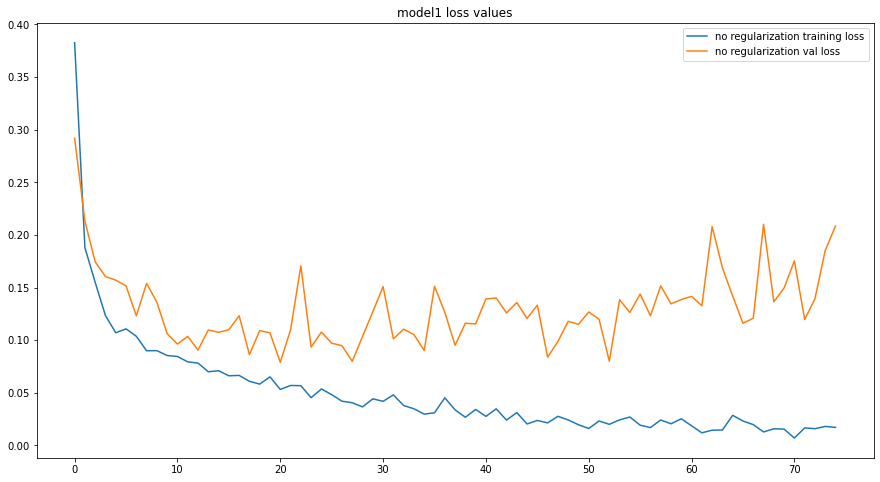

In [32]:
plt.figure(figsize=(15,8))

plt.plot(model1_history2.history['loss'],label = "no regularization training loss")
plt.plot(model1_history2.history['val_loss'],label = "no regularization val loss")
plt.legend()
plt.title("model1 loss values")
plt.show()

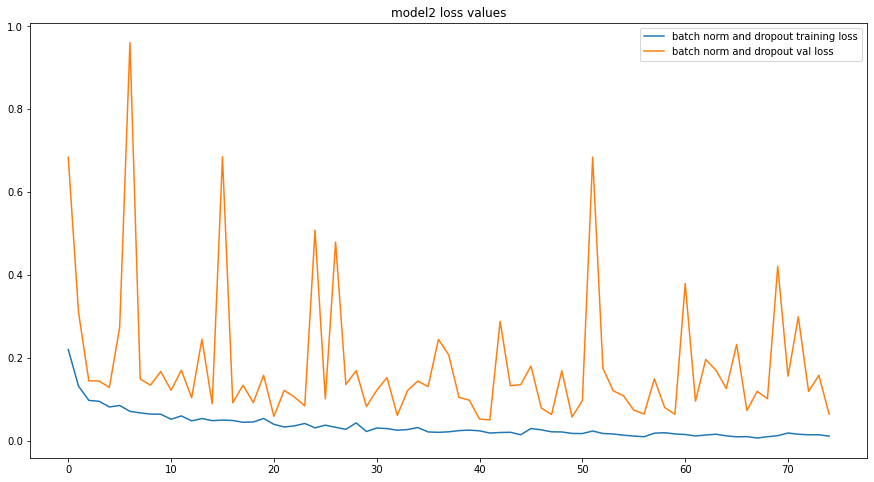

In [33]:
plt.figure(figsize=(15,8))
plt.plot(model2_history.history['loss'],label = "batch norm and dropout training loss")
plt.plot(model2_history.history['val_loss'],label = "batch norm and dropout val loss")
plt.legend()
plt.title("model2 loss values")
plt.show()

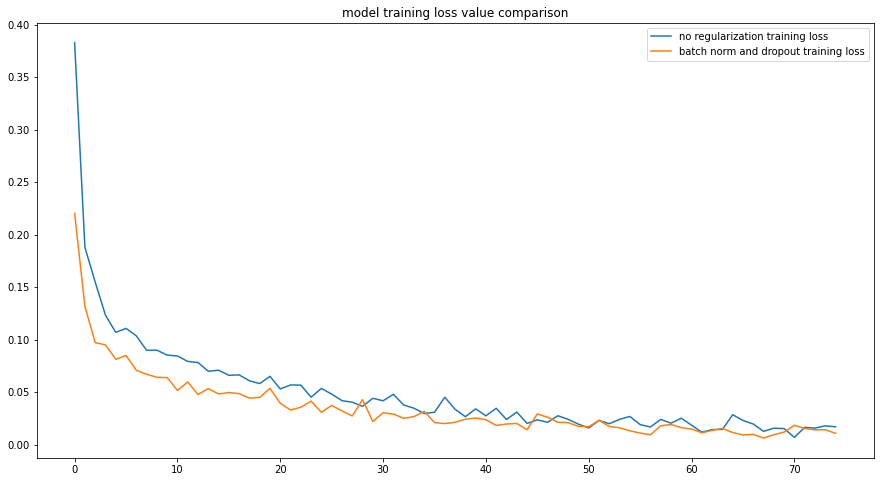

In [34]:
plt.figure(figsize=(15,8))

plt.plot(model1_history2.history['loss'],label = "no regularization training loss")
#plt.plot(model1_history2.history['val_loss'],label = "no regularization val loss")

plt.plot(model2_history.history['loss'],label = "batch norm and dropout training loss")
#plt.plot(model2_history.history['val_loss'],label = "batch norm and dropout val loss")

plt.legend()
plt.title("model training loss value comparison")
plt.show()

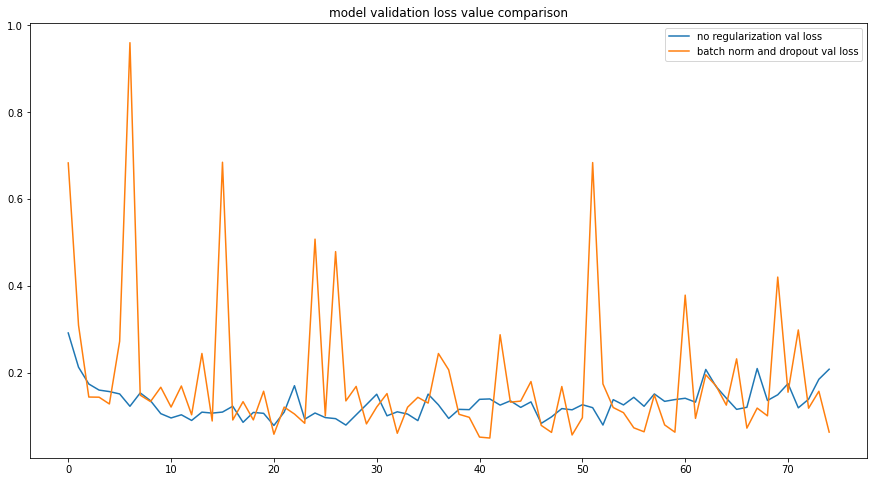

In [35]:
plt.figure(figsize=(15,8))

#plt.plot(model1_history2.history['loss'],label = "no regularization training loss")
plt.plot(model1_history2.history['val_loss'],label = "no regularization val loss")

#plt.plot(model2_history.history['loss'],label = "batch norm and dropout training loss")
plt.plot(model2_history.history['val_loss'],label = "batch norm and dropout val loss")

plt.legend()
plt.title("model validation loss value comparison")
plt.show()

Regularization seems to have increased validation loss overall without affecting training currently unsure how to interpret this. 